In [1]:
# please upload data directory to Google drive
# use Google Drive to load data
from google.colab import drive, files
import zipfile
drive.mount('/content/drive')

zipname = 'supports.zip'
uploaded = files.upload()
# Extract the zip file
with zipfile.ZipFile(zipname, 'r') as zip_ref:
  zip_ref.extractall()  # Extract all files to the current directory

Mounted at /content/drive


Saving supports.zip to supports.zip


In [2]:
!pip install -r "requirements.txt"
!pip install torchinfo
!pip install torcheval
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.9/171.9 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.0/812.0 kB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 990.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [3]:
from sklearn.model_selection import train_test_split
from models.AST import AST
import librosa
import numpy as np
from torchinfo import summary
from torch import nn
from torch.optim import Adam
from Utils import read_data,create_dataloader, k_fold_cross_validation, train, test
import matplotlib.pyplot as plt

# Read Data

In [4]:
root = '/content/drive/MyDrive/Data/genres_original' # Change according path storing data
sr = 16 * 1000
x,y,min_length = read_data(root=root, sr=sr)
print("finsh reading data")

finsh reading data


# Conversion, Compression and Normalisation

In [5]:
top_db = 80
for i in range(len(x)):
    signal = x[i][:min_length]
    mel_spect = librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=1024) # convert signals to mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max, top_db=top_db) # log compression
    x[i] = mel_spect/-top_db # normalisation
print("finish conversion and compression")

finish conversion and compression


# Split Data

In [6]:
x = np.asarray(x)
x = x.transpose((0,2,1))
y = np.asarray(y)
print(x.shape)

(1000, 936, 128)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=y,shuffle=True)
# k-fold cross validation
k = 5
xs_train, ys_train, xs_valid, ys_valid = k_fold_cross_validation(x_train,y_train,k)
print("finish splitting data")

finish splitting data


# Create Dataloaders

In [8]:
batch_size = 16
dataloaders_train = []
dataloaders_valid = []
for i in range(k):
    dataloaders_train.append(create_dataloader(xs_train[i], ys_train[i], batch_size=batch_size))
    dataloaders_valid.append(create_dataloader(xs_valid[i], ys_valid[i], batch_size=batch_size))
dataloader_test = create_dataloader(x_test, y_test, batch_size=batch_size)
print("finish creating dataloaders")

finish creating dataloaders


# Model Construction

In [9]:
model = AST(10,input_fdim=x.shape[2],input_tdim=x.shape[1])
model.cuda()
loss_function = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=1e-5)
summary(model,[(batch_size,x.shape[1],x.shape[2])])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

frequncey stride=10, time stride=10
number of patches=1116


Layer (type:depth-idx)                   Output Shape              Param #
AST                                      [16, 10]                  2,398,160
├─VisionTransformerDistilled: 1-3        --                        (recursive)
│    └─ASTPatchEmbed: 2-1                [16, 1116, 768]           --
│    │    └─Conv2d: 3-1                  [16, 768, 12, 93]         197,376
│    └─Dropout: 2-2                      [16, 1118, 768]           --
├─ModuleList: 1-2                        --                        --
│    └─Block: 2-3                        [16, 1118, 768]           --
│    │    └─LayerNorm: 3-2               [16, 1118, 768]           1,536
│    │    └─Attention: 3-3               [16, 1118, 768]           2,362,368
│    │    └─Identity: 3-4                [16, 1118, 768]           --
│    │    └─Identity: 3-5                [16, 1118, 768]           --
│    │    └─LayerNorm: 3-6               [16, 1118, 768]           1,536
│    │    └─Mlp: 3-7                     [16, 1118,

# Train

In [10]:
epoch = 10
history = train(model,loss_function,opt,dataloaders_train,dataloaders_valid,k,epoch=epoch)
print("finish training")

-------epoch  1 -------
fold 1:
train set loss: 2.279736328125
train set accuracy: 0.13906250894069672
valid set loss: 2.162890625
valid set accuracy: 0.3062500059604645
fold 2:
train set loss: 2.194384765625
train set accuracy: 0.2593750059604645
valid set loss: 2.1611328125
valid set accuracy: 0.29375001788139343
fold 3:
train set loss: 2.163671875
train set accuracy: 0.2906250059604645
valid set loss: 2.0556640625
valid set accuracy: 0.4625000059604645
fold 4:
train set loss: 2.10576171875
train set accuracy: 0.39531251788139343
valid set loss: 2.03388671875
valid set accuracy: 0.550000011920929
fold 5:
train set loss: 2.079345703125
train set accuracy: 0.46875
valid set loss: 2.00927734375
valid set accuracy: 0.512499988079071
epoch loss: 2.085
epoch accuracy: 0.425
-------epoch  2 -------
fold 1:
train set loss: 2.0537109375
train set accuracy: 0.518750011920929
valid set loss: 2.00244140625
valid set accuracy: 0.6000000238418579
fold 2:
train set loss: 2.0404541015625
train set a

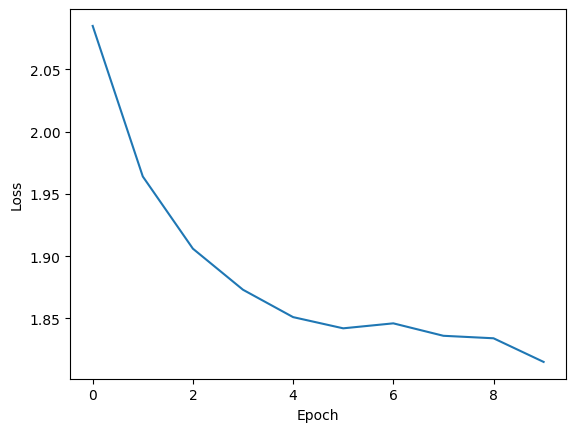

In [11]:
plt.plot(range(epoch),history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

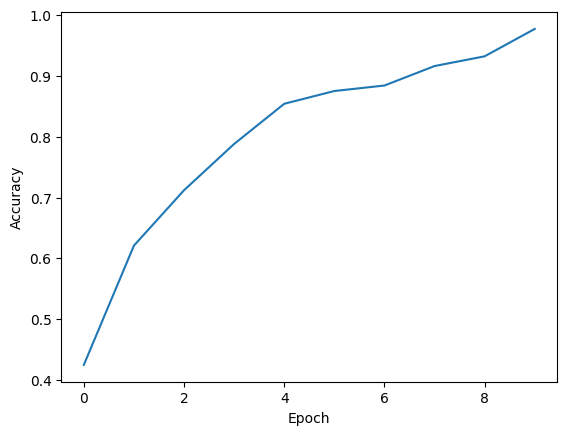

In [12]:
plt.show()
#%%
plt.plot(range(epoch),history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test

In [13]:
loss, acc, AUC, f1 = test(model,loss_function,dataloader_test)

test set loss: 1.904
test set accuracy: 0.78
test set AUC: 0.869
test set f1-score: 0.78
